# Project 1

In [480]:
# Import the dependencies
import time

import matplotlib.pyplot as plt
import cv2 as cv
from math import atan, degrees
from numba import jit
from numpy import argmin, argmax, array, ascontiguousarray, empty, exp, ma, ndarray, nonzero, histogram, random, round, zeros
from numpy.linalg import inv, svd
# from pandas import DataFrame
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from tslearn.clustering import KernelKMeans

In [509]:
# Set true for the final version to deliver!
final = False

In [434]:
# Some help functions
def log(msg):
    t = time.localtime()
    curr_time = time.strftime("%H:%M:%S", t)
    print(curr_time, msg)


# Give the homogeneity, completeness & accuracy score for the given labeling
def scores(true_labels, labels):
    hom = homogeneity_score(true_labels, labels)
    com = completeness_score(true_labels, labels)
    acc = accuracy_score(true_labels, labels)
    
    return hom, com, acc


# Visualize the given centroids
def showCentroids(c):
    print('Centroids:')
    plt.figure(figsize=(20, 10))
    if isinstance(c, DataFrame):
        c = c.to_numpy()
    for i, x in enumerate(c):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x.reshape(28, 28))
        plt.axis('off')
    plt.show()


# Show 10x zero, 10x one, ..., 10x nine
def show10(X, y):
    K = 10

    # For each digit 0, ..., 9, retrieve 10 samples
    plt.figure(figsize=(10, 10))
    n = 1
    for k in range(K):
#         Xk = X.loc[y == k].sample(K)
        Xk = X.loc[y == k].head(K)
        for i, x in Xk.iterrows():
            plt.subplot(10, 10, n)
            plt.imshow(x.values.reshape(28, 28))
            plt.axis('off')
            n += 1
    plt.show()

In [435]:
# Load the data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
print('The data are loaded')

The data are loaded


In [511]:
# For testing: Split the data set into a smaller training (& validation) set
if final:
    X_train = X
    y_train = y
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9)
log("Let us train using " + str(len(X_train)) + " samples.")

# Remove the original indices & scale X
X_train = X_train.reset_index(drop=True) / 255
y_train = y_train.astype('int').reset_index(drop=True)

# Just to get an impression of the data contents (labels)
print('Frequency per label:\n', y_train.value_counts())

# Convert the data to arrays
# X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

22:54:05 Let us train using 7000 samples.
Frequency per label:
 1    788
7    729
3    714
2    699
9    696
0    690
6    688
8    683
4    682
5    631
Name: class, dtype: int64


## Exercise 1a | K-Means Clustering
The K-means clustering algorithm has been implemented below.
It the algorithm uses the data $\texttt{X}$ as input and the number of clusters $\texttt{K}$.
$\texttt{y_true}$ are the true labels of the input data $\texttt{X}$ and are given only to compute the accuracy of the resulting clusters found by the algorithm.
Finally, $\texttt{metric}$ is a string representing the distance measure that is used, which is e.g. one of 'sqeuclidean', 'correlation' and 'gauss'.
By using 'sqeuclidean', the squared Euclidean distances will be computed between each pair of data vectors.
With 'correlation', the correlation between two samples will be used as distance measure.
A Gaussian distance measure $d_G$ is used for the input 'gauss', using a predefined value of $\gamma$.
We define $d_G$ as
$$
d_G(x_i, x_j) = \exp \left( -\gamma \| x_i - x_j \|^2 \right).
$$

In [437]:
# @jit(nopython=True, parallel=True)
def kMeans(X, y_true, K: int, metric: str):
    log('Starting K-means clustering using the metric \'%s\'' % metric)
    
    # Randomly initialize the centroids c
    N, M = X.shape
    if isinstance(X, ndarray):
        c = X[random.randint(N, size=K)]
    else:
        c = X.sample(K).reset_index(drop=True)
    y = [-1] * N  # Labels

    ePrev = M * N + 1
    eNew = ePrev - 1
    while ePrev - eNew > 0:
        ePrev = eNew
        eNew = 0

        # Assign x_i to cluster k = argmin_j || x_i - c_j ||
        if isinstance(X, ndarray):
            # TODO: does not work wwell :(
            for i, x in enumerate(X):
                if metric == 'gauss':
                    gamma = .001
                    dists = cdist([x], c, 'sqeuclidean')
                    dists = exp(-gamma * dists)
                else:
                    dists = cdist([x], c, metric)
                y[i] = argmin(dists)

            # Update the centroid positions
            for k in range(K):
                Ck = X[[i for i, yi in enumerate(y) if yi == k]]  # Compute Ck = {x_i where the label y_i = k}
                if len(Ck) > 0:
                    c[k] = Ck.mean()                            # Centroid = the mean of the elements in Ck
                    eNew += cdist([c[k]], Ck).sum()             # Compute the error
                else:
                    # Try to find a good position for this centroid
                    c[k] = c.mean()
        else:
            for i, x in X.iterrows():
                if metric == 'gauss':
                    gamma = .001
                    dists = cdist([x.array], c, 'sqeuclidean')
                    dists = exp(-gamma * dists)
                else:
                    dists = cdist([x.array], c, metric)
                y[i] = argmin(dists)

            # Update the centroid positions
            for k in range(K):
                Ck = X.loc[[i for i, yi in enumerate(y) if yi == k]]  # Compute Ck = {x_i where the label y_i = k}
                if len(Ck) > 0:
                    c.loc[k] = Ck.mean()                            # Centroid = the mean of the elements in Ck
                    eNew += cdist([c.loc[k]], Ck).sum()             # Compute the error
                else:
                    # Try to find a good position for this centroid
                    c.loc[k] = c.mean()
    
    # Determine the accuracy
    a = 0
    for k in range(K):
        Lk = y_true[[i for i, yi in enumerate(y) if yi == k]]  # Lk = {y_true_i : y_i = k}
        Lk = DataFrame(data=Lk)
        cnt = Lk.value_counts()
        cnt = cnt.values
        if len(cnt) > 0:
            a += cnt[0]
    a /= N
    
#     showCentroids(c)

    return y, a  # Return the labels

In [ ]:
def doCluster(X, y, show=True, onlyKMeans=False):
    K = 10
    
    def A(kmeans):
        c = kmeans.cluster_centers_
        y_found = kmeans.labels_
        s = 0
        for k in range(K):
            df = DataFrame(data=y[y_found == k])
            cnt = df.value_counts()
            s += cnt.values[0]
        return s / len(X)
    
    
    # Apply the K-means clustering algorithm using the square Euclidean distance measure
    start = time.time()
#     XX = X.to_numpy
    myLabels, a1 = kMeans(X, y, K, 'sqeuclidean')
    t1 = time.time() - start
    myScore = scores(y, myLabels)
    
    if not onlyKMeans:
        # Use correlation as distance measure
        start = time.time()
        myLabels2, a2 = kMeans(X, y, K, 'correlation')
        t2 = time.time() - start
        myScore2 = scores(y, myLabels2)

        # Use the Gaussian distance measure
        start = time.time()
        myLabels3, a3 = kMeans(X, y, K, 'gauss')
        t3 = time.time() - start
        myScore3 = scores(y, myLabels3)

    # Use an existing algorithm
    start = time.time()
#     kmeans = KMeans(n_clusters=K, random_state=1).fit(X)
    kmeans = KMeans(n_clusters=K, init='k-means++').fit(X)  # Slight speedup
    t = time.time() - start
    score = scores(y, kmeans.labels_)
    
    # Print the results
    if onlyKMeans:
        log('Results:\nAlgorithm \tHomogeneity Completeness   Accuracy   Time [s]\n'
            'My K-Means \t%11.4f %12.4f %10.1f%% %9.3f' % (myScore[0], myScore[1], a1*100, t1) +
            '\nExist. K-Means\t%11.4f %12.4f %10.1f%% %9.2f' % (score[0], score[1], A(kmeans)*100, t))
    else:
        log('Results:\nAlgorithm \tHomogeneity Completeness   Accuracy   Time [s]\n'
            'My K-Means \t%11.4f %12.4f %10.1f%% %9.3f' % (myScore[0], myScore[1], a1*100, t1) +
            '\nMy K-Means corr.%11.4f %12.4f %10.1f%% %9.2f' % (myScore2[0], myScore2[1], a2*100, t2) +
            '\nMy K-Means gauss.%10.4f %12.4f %10.1f%% %9.2f' % (myScore3[0], myScore3[1], a3*100, t3) +
            '\nExist. K-Means\t%11.4f %12.4f %10.1f%% %9.2f' % (score[0], score[1], A(kmeans)*100, t))
    
    if show:
        showCentroids(kmeans.cluster_centers_)
    
    return [a1, a2, a3, A(kmeans)], [t1, t2, t3, t]

In order to compare the performance of our K-Means algorithm with an existing Python imlementation, we have tested the performance using the function $\texttt{sklearn.cluster.KMeans}$. The results are listed below.
The 10 images that are shown below are visualizations of the 10 centres found by the K-Means algorithm.

21:47:10 Starting K-means clustering using the metric 'sqeuclidean'
21:51:11 Starting K-means clustering using the metric 'correlation'
22:05:10 Starting K-means clustering using the metric 'gauss'
22:06:41 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.4971       0.5187       59.9%   240.966
My K-Means corr.     0.5141       0.5213       60.1%   838.551
My K-Means gauss.    0.1017       0.1977       21.0%    29.848
Exist. K-Means	     0.4965       0.5038       58.5%    61.181
Centroids:


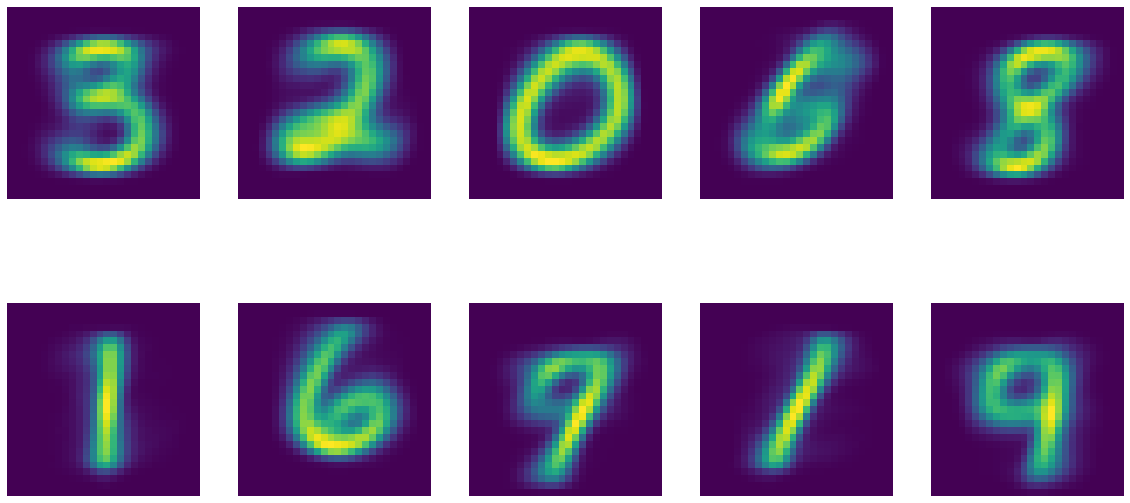

In [498]:
doCluster(X_train, y_train);

## Exercise 1b | Kernelized Clustering
Let $\phi$ be a function that transforms the original image vector $x$ to $\phi(x)$. Then the kernel would be $K(x_1, x_2) = \phi(x)^T \phi(x)$.
In the following code, we implement a function $\phi$ which consists of several image processing steps.
These are:
* Blurring;
* Equalization;
* Rotation correction.

**Blurring**: In order to account for small inaccuracies/noise (or speckles, etc.) in the written digit, we use a small Gaussian blurring function.
The Gaussian function in 2D is defined as
$$
G(x,y) = \frac{1}{2\pi \sigma^2} \exp\left( -\frac{x^2 - y^2}{2\sigma^2} \right),
$$
where $x$ and $y$ define the distance from the center pixel.

A socalled (discrete) Gaussian kernel (or convolution matrix) $K_G$ of size $3\times 3$ is equal to $(K_G)_{x,y} = cG(x,y)$, where $c$ is a constant such that the elements of $K_G$ sum to 1.

In [440]:
k = cv.getGaussianKernel(3, 0)  # Get the 1D Gaussian kernel
print('1D:', k)
print('2D:', k @ k.T)           # Print the 2D Gaussian kernel

1D: [[0.25]
 [0.5 ]
 [0.25]]
2D: [[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


The library OpenCV has a function called $\texttt{GaussianBlur}$ to apply this kernel as filtering (convolution) operation. Given that $\texttt{sigmaX = 0}$ is parsed to this function, $\texttt{GaussianBlur}$ computes the variance $\sigma^2$ derived from the size of $K_G$.

**Equalization**:
Some digits are written very light and some heavy (bold). In order to make these differences smaller, (histogram) equalization is applied.
Suppose that an image is given with values in the range 0 to 255 (uint8), having a maximum pixel value of 100. Then equalization creates a mapping $h$ from each current pixel value $v$ to a new pixel value $h(v)$, making e.g. 100 255. This mapping $h$ is as follows.
$$
{\displaystyle h(v)=\mathrm {round} \left({\frac {\operatorname {cdf} (v)-\operatorname {cdf} _{\min }}{(M\times N)-\operatorname {cdf} _{\min }}}\times (L-1)\right)}
$$
where cdf$_{\text{min}}$ is the minimum non-zero value of the cumulative distribution function (in this case 1), $M\times N$ gives the image's number of pixels and $L$ is the number of grey levels used.
cdf$(v)$ denotes the cumulative distribution function of the pixel value $v$.

In [441]:
# Equalize the histogram
def equalize(img):
    hist, bins = histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]

**Rotation Correction**:
Our image rotation correction function comprises a rotation detection step, giving the rotation angle, which is used to rotate the image over that angle.

*Rotation Detection*:
In order to make an approximation of the rotation of the written digit, firstly, we compute the average index of the non-zero pixels per row.
Then we fit a line through these points, using a linear least squares (LLS).

Let the linear approximation be $f_{a,b}(x) = a + bx$. Let the residual for vector $i$ be $r_i(a,b) = y_i - f_{a,b}(x_i), i = 1,...,|X|$.
LLS minimizes the sum $S(a,b) = \sum_{i = 1}^{|X|} r_i^2(a,b)$.
The optimal values for $a$ and $b$ can be found by solving $\frac{\partial S}{\partial a} = \frac{\partial S}{\partial b} = 0$.

In [442]:
# Given a set of points with coordinates (x,y) in X x Y, find the best line fit y = a + b * x & return a, b.
# Based on code from https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def fitLine(X, Y):
    xbar = sum(X) / len(X)
    ybar = sum(Y) / len(Y)
    n = len(X)

    numer = sum([xi * yi for xi, yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

#     print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))
    
    return a, b

Given the slope $b$, the rotation angle is atan$(b)$ rad. Hence the correction rotation angle is -atan$(b)$ rad.

*Rotation Correction*:
In order to rotate the image over the given angle, we compute a rotation matrix. Say that a rotation of angle $\theta$ is done of a $2\times 2$ image, the rotation matrix $R_\theta$ is as follows.
$$
{\displaystyle R_\theta = {\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \end{bmatrix}}}
$$
Given the input image vector $x$, the rotated image is $x' = R_\theta x$.
This can be generalized for larger input and output vectors.
The resulting vector $x'$ is the original image $x$, rotated over angle $\theta$.

Why is rotating the image useful? Suppose we have two written ones, where the one is exactly vertically aligned and the other has a slope of 30 degrees. Then the Euclidean distance between the corresponding image vectors might be large and as a result, the ones may belong to different clusters after applying the K-means clustering algorithm. Using the rotation correction function, we try to prevent this.

In [443]:
# Rotate the given image by [angle] degrees
# Inspired by https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate(img, angle):
#     print('rotate {:.2f} deg'.format(angle))
    img_center = tuple(array(img.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(img_center, angle, 1.0)
    return cv.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv.INTER_LINEAR)


# Detect & correct the rotation of the written digit
def correctRotation(img):
    nz = nonzero(img)                       # Find the mean index of the nonzeros per row
    df = DataFrame(data=nz)
    means = df.T.groupby(0).mean()
    inds = means.index.to_numpy()           # Make it an ndarray
    _, b = fitLine(inds, means[1].values)   # Fit a line (y = a + b * x) in order to detect the rotation
    return rotate(img, degrees(atan(-b)))   # Rotate the image


# Sharpen the given image
def sharpen(img):
    sharpen_filter = array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv.filter2D(img, -1, sharpen_filter)
    
    return img


# Define an image processing function. Use r as radius for the Gaussian blurring step
def procImg(img, r):
    img = (255 * img).astype('uint8')      # Convert the image to uint8 to process it
    img = cv.GaussianBlur(img, (r, r), 0)  # Blur
    img = cv.equalizeHist(img)             # Equalize
    # Other tries were the following, though they did not improve the clustering accuracy.
#     img = equalize(img)
#     img = sharpen(img)                     # Sharpen
#     img = setBounds(img)
#     img[img < 80] = 0  # Threshold
#         # img = cv.Canny(img, 30, 150)    # Edge detection
        # Sum each row and put the value in the right most pixel
#         img[:,27] = sum(img, 2)
#         img[27,:] = sum(img, 1)
    img = correctRotation(img)
#     img = correctRotation(img)  # Try a second correction
    
    return img.astype('float32') / 255

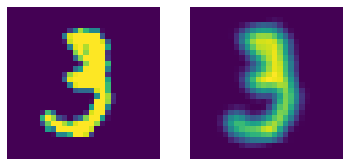

In [502]:
# Test the image processor
img = X_train.loc[10].values.reshape(28, 28)
imgP = procImg(img, 3)

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(imgP)
plt.axis('off')
plt.show;

In [517]:
# Process the images. Use r as radius for the Gaussian blurring step.
def process(X: ndarray, r):
    X_proc = X.copy()
    for i, x in enumerate(X_proc):

        # Process image x
        img = x.reshape(28, 28)
        img = procImg(img, r)
        X_proc[i] = img.reshape(784)
    
    return X_proc

In order to test which value to take as blurring radius r, we do the image processing using this radius and then run the K-means clustering algorithm 3 times per value $r \in [1, 3, 5, 7]$. The resulting average accuracy is logged and shown below. The best radius is picked and used in the next image processing steps.

In [519]:
# Test the performance (resulting accuracy) of applying K-means after a blurring step
print('Note:', len(X_train), 'samples are used.')
K = 10
r_max = 7
r_vals = range(1, r_max + 1, 2)
a = [0] * len(r_vals)            # Accuracy
t = [0] * len(r_vals)            # Processing times
for i in range(len(r_vals)):
    r = r_vals[i]
    log('Test r = {:d}'.format(r))
    
    # Process the images using blurring radius r
    t_i = time.time()
    X_proc = process(X_train_arr, r)
    t[i] = time.time() - t_i
    
    # Cluster the processed data using K-Means & record the accuracy (mean over several runs)
    n_acc = 3
    acc = 0
    for j in range(n_acc):
        _, acc_j = kMeans(X_proc, y_train, K, 'sqeuclidean')
        acc += acc_j
    a[i] = acc / n_acc

Note: 7000 samples are used.
23:35:41 Test r = 1
23:36:12 Starting K-means clustering using the metric 'sqeuclidean'
23:36:15 Starting K-means clustering using the metric 'sqeuclidean'
23:36:18 Starting K-means clustering using the metric 'sqeuclidean'
23:36:21 Test r = 3
23:37:07 Starting K-means clustering using the metric 'sqeuclidean'
23:37:09 Starting K-means clustering using the metric 'sqeuclidean'
23:37:17 Starting K-means clustering using the metric 'sqeuclidean'
23:37:19 Test r = 5
23:38:15 Starting K-means clustering using the metric 'sqeuclidean'
23:38:17 Starting K-means clustering using the metric 'sqeuclidean'
23:38:23 Starting K-means clustering using the metric 'sqeuclidean'
23:38:27 Test r = 7
23:39:39 Starting K-means clustering using the metric 'sqeuclidean'
23:39:44 Starting K-means clustering using the metric 'sqeuclidean'
23:39:48 Starting K-means clustering using the metric 'sqeuclidean'


7000 samples were used.
The best radius is 3 , giving an accuracy of 73.1 %.
The resulting processing time is approx. 91 s.


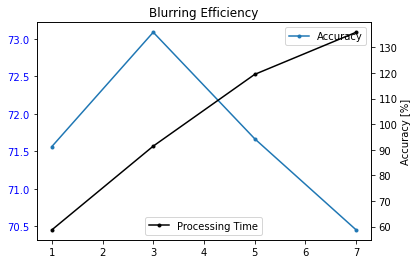

In [513]:
# Plot the results
print(len(X_train), 'samples were used.')
# print('The average image processing time for this data set was', array(t).mean(), 's.')

def plotAccTime(x_vals, x_label, a, t, title):
    # Plot the accuracy
    fig, ax = plt.subplots()
    ax.plot(x_vals, 100 * array(a), '.-')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.legend(['Accuracy'])

    # Plot the image processing time
    ax2 = ax.twinx()
    ax2.plot(x_vals, t, '.-k')
    ax2.legend(['Processing Time'], loc='lower center')
    plt.xlabel(x_label)
    plt.ylabel('Accuracy [%]')
    plt.title(title)

plotAccTime(r_vals, 'Radius r', a, t, 'Blurring Efficiency')

# Select the best radius r
r_best = r_vals[argmax(a)]
# r_best = 3
print('The best radius is', r_best, ', giving an accuracy of {:2.1f} %.\nThe resulting processing time is approx. {:.0f} s.'.format(100 * max(a), t[argmax(a)]));

In [516]:
# Reprocess the data using the best radius r_best
print('Processing')
t0 = time.time()
X_proc = process(X_train_arr, r_best)
print('Time:', time.time() - t0)

Time: 49.748223066329956


In [ ]:
# Test X_proc as the result of process. Is it as expected?
img = X_proc.loc[10].values.reshape(28, 28)
plt.imshow(img)
plt.axis('off')
plt.show;

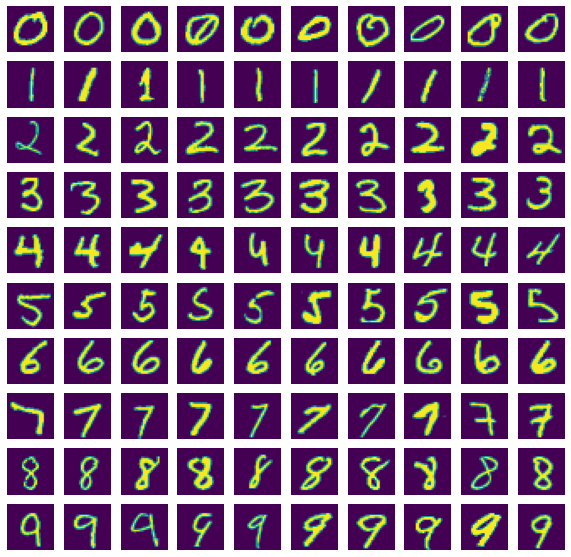

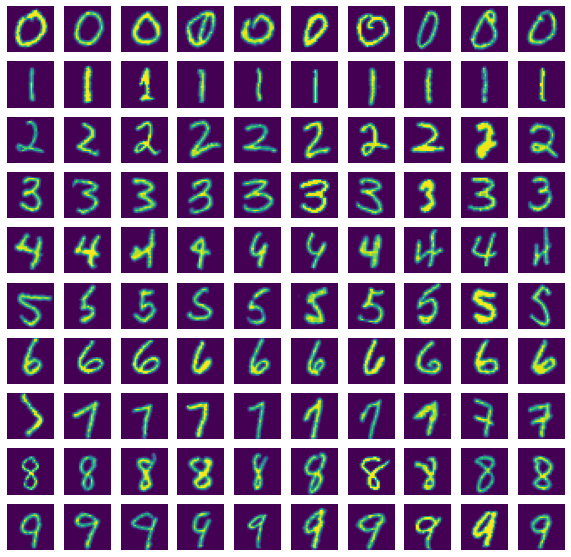

In [450]:
# Show some results
show10(X_train, y_train)
show10(X_proc, y_train)

21:11:02 Starting K-means clustering using the metric 'sqeuclidean'
21:11:24 Starting K-means clustering using the metric 'correlation'
21:11:40 Starting K-means clustering using the metric 'gauss'
21:11:46 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.6126       0.6232       69.1%    21.836
My K-Means corr.     0.6208       0.6403       70.3%    16.081
My K-Means gauss.    0.1395       0.2666       25.5%     1.086
Exist. K-Means	     0.6159       0.6295       68.9%     4.695
Centroids:


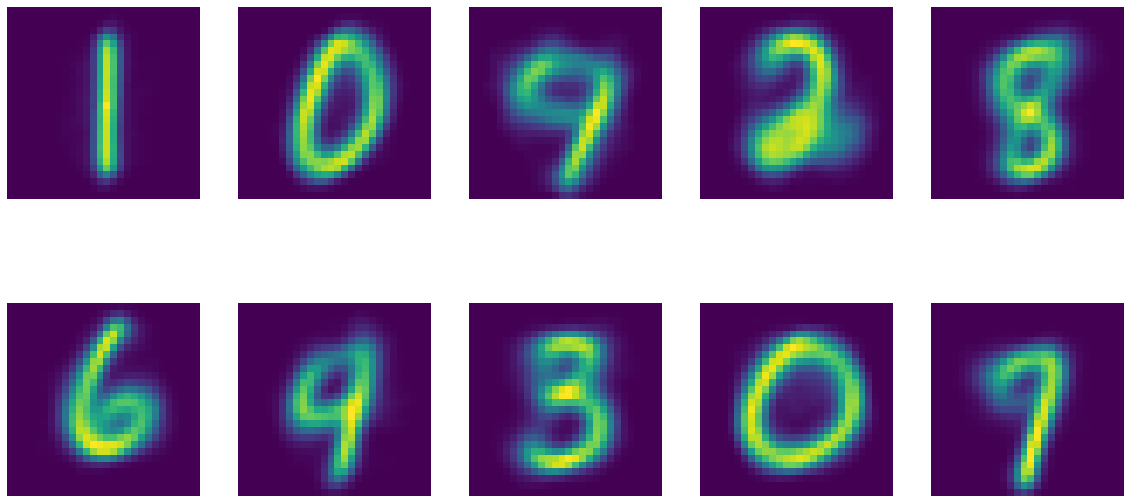

In [479]:
# Apply the clustering algorithm on the processed images
doCluster(X_proc, y_train, onlyKMeans=True);

Now, we clearly see that there is exactly one cluster for ones as expected, due to the rotation correction.

In [452]:
# Use a 
# km = KernelKMeans(n_clusters=3,
#                       kernel="gak",
#                       kernel_params={"sigma": "auto"},
#                       n_init=20,
#                       verbose=True,
#                       random_state=408431)
# y_pred = km.fit_predict(X_train)
# print(score(y, y_pred))

## Exercise 2a | Graph Laplacian
The unnormalized graph Laplacian is defined by $L = D - W$, where $W$ is the weight matrix such that $W_{ij} = K(x_i, x_j)$ and $D = \text{diag}(W)$.

In [453]:
# Construct a graph Laplacian matrix L = D - W
# Inspired by https://towardsdatascience.com/optimising-pairwise-euclidean-distance-calculations-using-python-fc020112c984
def laplacian(X):
    gamma = .001
    N = len(X)
    L = empty((N, N), dtype='float32')
    for i in range(N):
        L[i, :] = ((X - X.loc[i])**2).sum(axis=1)  # Compute the square Euclidean distance
        # Compute a polynomial distance (1 + x_i^T @ x_j)^r
#         L[i, :] = -exp(-gamma * L[i, :])   # Compute a Gaussian distance exp(-gamma * |x_i - x_j|^2)
#         L[i, i] = 0
    
    return L

In [454]:
t0 = time.time()
L = laplacian(X_train)
t = time.time() - t0

In [455]:
print('Computing the Laplacian costed {:.2f} s'.format(t))
print('Size:', L.shape)

Computing the Laplacian costed 78.81 s
Size: (3500, 3500)


In [456]:
# Compute the K eigenvectors corresponding to the K smallest eigenvalues of L
t0 = time.time()
w, vecs = eigsh(L, K, sigma=0)      # Find K eigenvalues near zero using shift-invert mode
t = time.time() - t0

In [457]:
print('Finding the eigenvectors costed {:.2f} s'.format(t))
print('Size:', vecs.shape)

Finding the eigenvectors costed 1.56 s
Size: (3500, 10)


In [458]:
doCluster(vecs, y_train, False);

21:00:31 Starting K-means clustering using the metric 'sqeuclidean'
21:00:33 Starting K-means clustering using the metric 'correlation'
21:00:33 Starting K-means clustering using the metric 'gauss'
21:00:40 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.0075       0.0080       13.0%     1.459
My K-Means corr.     0.0000       1.0000       11.3%     0.365
My K-Means gauss.    0.0002       0.0008       11.3%     0.796
Exist. K-Means	     0.0048       0.0048       12.6%     5.434


([0.13, 0.11257142857142857, 0.11257142857142857, 0.126],
 [1.4586036205291748,
  0.3647925853729248,
  0.7960186004638672,
  5.434110403060913])

## Exercise 2b | Self-made Function eigsh
In order to find the $K$ smallest eigenvalues of $L$, it is useful to exploit the matrix structure. Note that it is Hermition, since $L = L^T$. Therefore, we can use the Lanczos algorithm or QR-factorizations. Lanczos method is prone to numerical instability and therefore, we have chosen to use a method based on QR-factorizations.
// Inverse Power method
// explicitly shifted QR algorithm
// implicitly shifted QR algorithm

In [483]:
# Compute the k smallest eigenvalues of the given matrix A
def our_eigsh(A, k):
#     a_inv = inv(A)

#     for i in range(8):
#         x = a_inv @ x
#         l_1, x = normalize(x)

#     print('Eigenvalue:', l_1)
#     print('Eigenvector:', x)
    return [k], A


# Compute the K eigenvectors corresponding to the K smallest eigenvalues of L
t0 = time.time()
w, vecs = our_eigsh(L, K)      # Find K smallest eigenvalues
t = time.time() - t0

In [461]:
print('Finding the eigenvectors costed {:.2f} s'.format(t))
print('Size:', vecs.shape)

Finding the eigenvectors costed 0.00 s
Size: (3500, 3500)


## Exercise 3 | Compressed Images


In [490]:
# Compress the images using L eigenvalues
# @jit(parallel=True)
def compress(X, l):
    X_comp = X.copy()
    
    for i, x in enumerate(X):
        # Compress each image & use only l eigenvalues
        img = x.reshape(28, 28)
        u, s, vh = svd(img)
        X_comp[i] = ((u[:, :l] * s[0:l]) @ vh[:l, :]).reshape(784)
    
    return X_comp

In [492]:
# Test the compression function
X_proc_arr = array(X_proc.to_numpy())
t0 = time.time()
X_pc = compress(X_proc_arr, 8)      # Compressed & processed images
print('Compressed in {:.3f} s'.format(time.time() - t0))

Compressed in 0.570 s


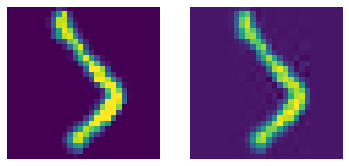

In [493]:
plt.subplot(1,2,1)
plt.imshow(X_proc_arr[0].reshape(28, 28))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X_pc[0].reshape(28, 28))
plt.axis('off')
plt.show;

21:39:27 l = 4
21:39:28 Starting K-means clustering using the metric 'sqeuclidean'
21:39:37 Starting K-means clustering using the metric 'correlation'
21:39:50 Starting K-means clustering using the metric 'gauss'
21:39:54 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.6360       0.6462       73.3%     9.708
My K-Means corr.     0.6215       0.6295       69.5%    12.977
My K-Means gauss.    0.0668       0.3591       18.7%     1.378
Exist. K-Means	     0.6471       0.6612       75.0%     2.687
21:39:55 Starting K-means clustering using the metric 'sqeuclidean'
21:40:10 Starting K-means clustering using the metric 'correlation'
21:40:28 Starting K-means clustering using the metric 'gauss'
21:40:33 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.6268       0.6316       71.9%    15.654
My K-Means corr.     0.6166       0.6304       69.1%    18.242
My K-Means gauss.    0.1175       0.3581       22.0%     1.374
Exist

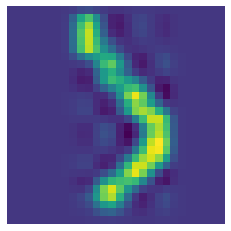

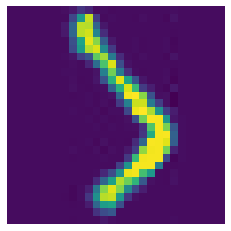

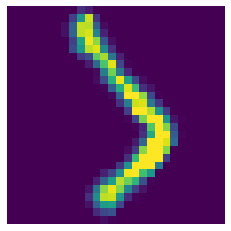

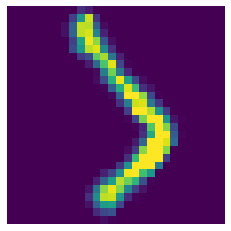

In [494]:
# For each l = 4, 8, ..., 28, compress the images & cluster them
l_vals = range(4, 28+1, 8)
# a = empty((len(l_vals), 4))
# t = empty((len(l_vals), 4))
a_proc = zeros((len(l_vals), 4))
t_proc = zeros((len(l_vals), 4))
t_comp = empty(len(l_vals))
for i, l in enumerate(l_vals):
    log('l = {:d}'.format(l))                     # Log the progress
    t0 = time.time()
    X_pc = compress(X_proc_arr, l)                # Compress the images
    t_comp[i] = time.time() - t0
    plt.figure()
    plt.imshow(X_pc[0].reshape(28, 28))
    plt.axis('off')
    plt.show
    
    # Cluster 3 times & report the average results
    for j in range(3):
        aa, tt = doCluster(DataFrame(data=X_pc), y_train, False)  # Run K-Means on the compressed & processed images
        a_proc[i] += aa
        t_proc[i] += tt
    a_proc[i] /= 3
    t_proc[i] /= 3
print('Done');

Note: 3500 samples were used.
The average compression time was 0.576 s
The best L is 4 , giving an accuracy of 71.9 %.
The resulting processing time is approx. 10 s.


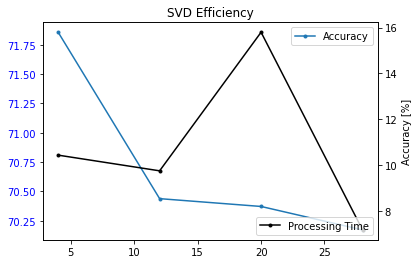

In [495]:
# Plot the results
print('Note:', len(X_train), 'samples were used.')
print('The average compression time was {:.3f} s'.format(array(t_comp).mean()))
a_proc_km = a_proc[:, 0]  # Accuracy for our K-Means
t_proc_km = t_proc[:, 0]  # Processing time for our K-Means
plotAccTime(l_vals, 'L', a_proc_km, t_proc_km, 'SVD Efficiency')

# Select the best radius r
l_best = l_vals[argmax(a_proc_km)]
print('The best L is', l_best, ', giving an accuracy of {:2.1f} %.\nThe resulting processing time is approx. {:.0f} s.'.format(100 * max(a_proc_km), t_proc_km[argmax(a_proc_km)]))